# spellops

This section describes the `speLL` operators.

NOTE: we use default_exp __init__ in order to enable this as soon as you import the module.

In [ ]:
#| default_exp __init__

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import test_eq, test_fail, test_eq_type
import testcell

In [ ]:
#| export
# spellops: a new set of fastcore L operators for creating speLL
from fastcore.foundation import L,patch

## Testing utilities

In [ ]:
import io
from contextlib import redirect_stdout

def test_eq_stdout(f, expected):
    """
    Test if the output of function `f` matches the expected string.
    
    Args:
        f (callable): A parameterless function that prints to stdout.
        expected (str): The expected printed output.
    
    Raises:
        AssertionError: If the output does not match the expected string.
    """
    buffer = io.StringIO()
    with redirect_stdout(buffer):f()
    output = buffer.getvalue().strip()
    test_eq(output,expected)

In [ ]:
%%testcell
from fastcore.test import test_fail

def my_function(): print("Hello, world!")

# Successful test
test_eq_stdout(my_function, "Hello, world!")

# Failing test
test_fail(lambda: test_eq_stdout(my_function, "Hello, world ?"))

## `tee` operator
`tee` is a debugging and documentation tool that prints the current state of data transformation while allowing the chain to continue. Like its Unix namesake, it lets you "peek" at data flowing through a pipeline without interrupting it.

Sample use cases:
1. Debug Data Transformations
2. Document Pipeline Steps
3. Custom Visualization
4. Development/Teaching

In [ ]:
#| export
def _default_print(x, msg=None, sep='\n', **kwargs): print(f"{msg+sep if msg else ''}{x}")
@patch
def tee(self:L, msg=None, f=_default_print, show=True, **kwargs): 
    if show: f(self, **kwargs) if msg is None else f(self, msg, **kwargs)
    return self

In [ ]:
%%testcell
# Unit tests

# Default tests
test_eq_stdout(lambda:  L([1,2,3]).tee(),  "[1, 2, 3]")
test_eq_stdout(lambda:  L([1,2,3]).tee('values'),  "values\n[1, 2, 3]")
test_eq_stdout(lambda:  L([1,2,3]).tee('values', sep=':'),  "values:[1, 2, 3]")

# Advanced print
def my_print(x,msg,symbol): print(f'{symbol} {msg} : {x}')
test_eq_stdout(lambda:  L([1,2,3]).tee('values', f=my_print, symbol='!'),  "! values : [1, 2, 3]")

In [ ]:
# 1. Debug Data Transformations
(L(['1.2', '3.4', '-2.1'])
    .map(float).tee('After converting to float')
    .map(abs).tee('After taking absolute values'))

After converting to float
[1.2, 3.4, -2.1]
After taking absolute values
[1.2, 3.4, 2.1]


(#3) [1.2,3.4,2.1]

In [ ]:
# 2. Document Pipeline Steps
(L(['12', 'abc', '23', '0', 'x'])
    .map(lambda x: x if x.isdigit() else None).tee('Converted to int or None')
    .filter(lambda x: x is not None).tee('Filtered out non-numbers'))

Converted to int or None
['12', None, '23', '0', None]
Filtered out non-numbers
['12', '23', '0']


(#3) ['12','23','0']

In [ ]:
# 3. Custom Visualization (using emoji for fun)
custom_print = lambda x, msg: print(f"🔍 {msg}: {[f'item_{i}:{v}' for i,v in enumerate(x)]}")
(L([1, 2, 3, 4])
    .map(lambda x: x*2).tee('Doubled values', f=custom_print))

🔍 Doubled values: ['item_0:2', 'item_1:4', 'item_2:6', 'item_3:8']


(#4) [2,4,6,8]

In [ ]:
# 4. Development/Teaching
(L([{'a':1}, {'a':2}, {'a':3}])
    .tee('Starting with dictionaries')
    .map(lambda d: d['a']).tee('Extracted "a" values')
    .map(lambda x: x+10).tee('Added 10 to each value'))

Starting with dictionaries
[{'a': 1}, {'a': 2}, {'a': 3}]
Extracted "a" values
[1, 2, 3]
Added 10 to each value
[11, 12, 13]


(#3) [11,12,13]

With `tee` you can inspect the state of your pipeline with arbitrary complex functions:

In [ ]:
%%testcell
import numpy as np

def print_as_matrix(x:L, msg):
    print(msg)
    N = len(x)
    rows = len(x[0])
    for r in range(rows):
        row_str = (L([o[r] for o in x]).map(lambda o: ''.join(map(str,o))))
        row_str = '  '.join(row_str)
        print(row_str)

# Sums all the values of the first row of all matrices after rotating them of 90 degree
(L([[[0,0,0],[1,1,1],[0,0,0]],[[1,0,0],[0,1,0],[0,0,1]]])   .tee('Input images',f=print_as_matrix)
    .map(lambda x: np.rot90(x,k=1))     .tee('Rotate 90 degree',f=print_as_matrix)
    .map(lambda x: x[0].tolist())       .tee('Take first row')
    .map(sum)                           .tee('Sum element in list')
    .sum()
)

Input images
000  100
111  010
000  001
Rotate 90 degree
010  001
010  010
010  100
Take first row
[[0, 1, 0], [0, 0, 1]]
Sum element in list
[1, 1]


2

`tee` supports even rich "inspection" with external libraries such as `matplotlib`.

(#2) [array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]]),array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])]

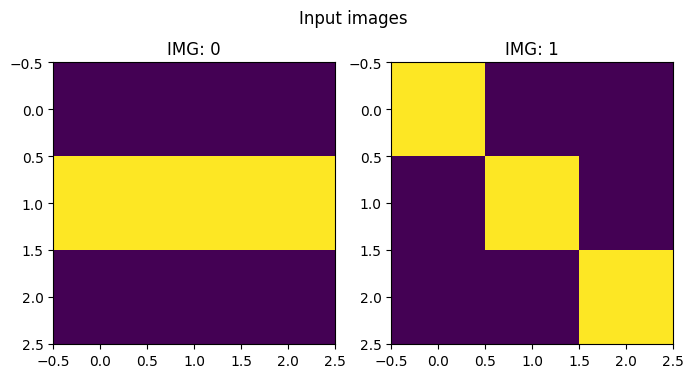

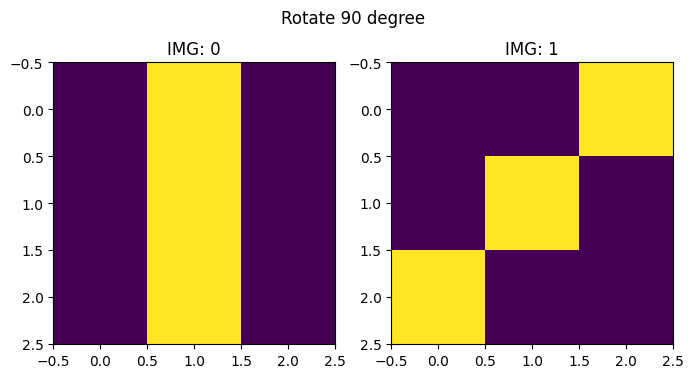

In [ ]:
%%testcell
# Advance tee
import matplotlib.pyplot as plt
import numpy as np

def plot_images(x:L, msg):
    N = len(x)
    plt.figure(figsize=(4*N,4))
    for i,o in enumerate(x):
        plt.subplot(1,N,i+1)
        plt.imshow(o)
        plt.title(f'IMG: {i}')
    plt.suptitle(msg)

(L([[[0,0,0],[1,1,1],[0,0,0]],[[1,0,0],[0,1,0],[0,0,1]]])  .tee('Input images',f=plot_images)
    .map(lambda x: np.rot90(x,k=1)) .tee('Rotate 90 degree',f=plot_images)
)

## `pipe` operator
`pipe` applies a function to the entire L collection, rather than to individual elements (like `map` does). With `wrap=True` (default) it returns an L for chaining, with `wrap=False` it returns the raw result.

**NOTE:** `pipen(f)` is an alias to `pipe(f,wrap=False)`

In [ ]:
#| export
@patch
def pipe(self:L, f, wrap=True): return self._new(f(self)) if wrap else f(self)
@patch
def starpipe(self:L, f, wrap=True): return self._new(f(*self)) if wrap else f(*self)

In [ ]:
%%testcell
test_eq(L([1,2,3]).pipe(len),L(3))
test_eq(L([1,2,3]).pipe(len, wrap=False),3)
test_eq(L([1,3]).starpipe(lambda a,b: a+b),L(4))
test_eq(L([1,3]).starpipe(lambda a,b: a+b, wrap=False),4)

In [ ]:
#| export
@patch
def pipen(self:L, f): return self.pipe(f=f,wrap=False)
@patch
def starpipen(self:L, f): return self.starpipe(f=f,wrap=False)

In [ ]:
%%testcell
test_eq(L([1,2,3]).pipen(len),3)
test_eq(L([1,3]).starpipen(lambda a,b: a+b),4)

In [ ]:
%%testcell
# Count how many elements of a reference set are present in a L
L([1,2,3,2]).pipe(lambda x: set(x).intersection({1,3,5})).pipe(len,wrap=False)

2

In [ ]:
L(['a', 'b', 'c']).pipe('->'.join, wrap=False)

'a->b->c'

In [ ]:
# Using the convenience `pipen`
L(['a', 'b', 'c']).pipen('->'.join)

'a->b->c'

You can solve this line by line and have it documented step by step:

In [ ]:
%%testcell
# Count how many elements are present in both sublists using a function with two parameters
(L([[1,2,3,2],[2,4,1]])    .tee('input')
     .map(set)             .tee('to set')
     .starpipe(set.intersection)  .tee('common elements')
     .pipe(len, wrap=False)
)

input
[[1, 2, 3, 2], [2, 4, 1]]
to set
[{1, 2, 3}, {1, 2, 4}]
common elements
[1, 2]


2

Or you can abstract part of the computation away and have it delegated to a custom function:

In [ ]:
%%testcell
# Count how many elements are present in both sublists using a function with two parameters
def count_intersection(a,b): return len(set(a)&set(b))
L([[1,2,3,2],[2,4,1]]).starpipe(count_intersection,wrap=False)

2

## `unwrap` operator
`unwrap` safely extracts a single value from an L collection, returning None for empty lists and raising an error if there are multiple elements. It's designed to safely terminate L-chains when you expect exactly one result.

In [ ]:
#| export
@patch
def unwrap(self:L): 
    if len(self)==0: return None # nothing to return 
    if len(self)!=1: raise ValueError("Can't unwrap list with more than one element")
    return self[0]

In [ ]:
%%testcell
test_eq(L([1]).unwrap(),1)
test_eq(L([]).unwrap(),None)
test_fail(lambda: L([1,2]).unwrap())

In [ ]:
%%testcell
# Count how many elements are present in both sublists
(L([[1,2,3,2],[2,4,1]])    .tee('input')
     .map(set)             .tee('to set')
     .starpipe(set.intersection)  .tee('common elements')
     .pipe(len)            .tee('count elements')
     .unwrap()
)

input
[[1, 2, 3, 2], [2, 4, 1]]
to set
[{1, 2, 3}, {1, 2, 4}]
common elements
[1, 2]
count elements
[2]


2

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()